# Facebook Live Sellers in Thailand

**Team**:

  - Ashvin Alex
  - Bastian Castillo
  - Marcelo Munoz
  - Sabin Pokhrel

**Course**: CBD 2214 - Big Data Fundamentals - Data Storage Networking

**Section**: 1

</br>
</br>

### Dataset: https://archive.ics.uci.edu/ml/datasets/Facebook+Live+Sellers+in+Thailand

### Metadata:

The variability of consumer engagement is analysed through a Principal Component Analysis, highlighting the changes induced by the use of Facebook Live. The seasonal component is analysed through a study of the averages of the different engagement metrics for different time-frames (hourly, daily and monthly). Finally, we identify statistical outlier posts, that are qualitatively analyzed further, in terms of their selling approach and activities.


Attribute Information:

- **status_id**: record id
- **status_type**: source of the record
- **status_published**: date and time of the record
- **num_reactions**: total number of reactions
- **num_comments**: total number of comments
- **num_shares**: total number the publication was shared
- **num_likes**: total number of likes reactions
- **num_loves**: total number of love reactions
- **num_wows**: total number of wows reaction
- **num_hahas**: total number of laughs reactions
- **num_sads**: total number of sads faces reactions
- **num_angrys**: total number of angry faces reactions

### 1) Load Data

In [287]:
import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns

In [123]:
dataset_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00488/Live_20210128.csv"
df = pd.read_csv(dataset_url)
df

,status_id,status_type,status_published,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys,Column1,Column2,Column3,Column4
0,1,video,4/22/2018 6:00,529,512,262,432,92,3,1,1,0,NaN,NaN,NaN,NaN
1,2,photo,4/21/2018 22:45,150,0,0,150,0,0,0,0,0,NaN,NaN,NaN,NaN
2,3,video,4/21/2018 6:17,227,236,57,204,21,1,1,0,0,NaN,NaN,NaN,NaN
3,4,photo,4/21/2018 2:29,111,0,0,111,0,0,0,0,0,NaN,NaN,NaN,NaN
4,5,photo,4/18/2018 3:22,213,0,0,204,9,0,0,0,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7045,7046,photo,9/24/2016 2:58,89,0,0,89,0,0,0,0,0,NaN,NaN,NaN,NaN
7046,7047,photo,9/23/2016 11:19,16,0,0,14,1,0,1,0,0,NaN,NaN,NaN,NaN
7047,7048,photo,9/21/2016 23:03,2,0,0,1,1,0,0,0,0,NaN,NaN,NaN,NaN
7048,7049,photo,9/20/2016 0:43,351,12,22,349,2,0,0,0,0,NaN,NaN,NaN,NaN


### 2) Missing values

In this phase, we are dealing with missing values. As seen, four columns do not make sense in the dataset because all of the columns are NaN values. So these columns will be omitted. The column status_id will be removed because it just represents the id of each record; in the same way, the column status_published also will be omitted because, for a clustering algorithm, it is not relevant; it just records the time of each data point.

In [124]:
print("Total records:", len(df))
df.isnull().sum()

Total records: 7050


status_id              0
status_type            0
status_published       0
num_reactions          0
num_comments           0
num_shares             0
num_likes              0
num_loves              0
num_wows               0
num_hahas              0
num_sads               0
num_angrys             0
Column1             7050
Column2             7050
Column3             7050
Column4             7050
dtype: int64

In [177]:
df_1 = df.drop(['status_id', 'status_published', 'Column1','Column2','Column3','Column4'],axis=1)
df_1

,status_type,num_reactions,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,529,512,262,432,92,3,1,1,0
1,photo,150,0,0,150,0,0,0,0,0
2,video,227,236,57,204,21,1,1,0,0
3,photo,111,0,0,111,0,0,0,0,0
4,photo,213,0,0,204,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
7045,photo,89,0,0,89,0,0,0,0,0
7046,photo,16,0,0,14,1,0,1,0,0
7047,photo,2,0,0,1,1,0,0,0,0
7048,photo,351,12,22,349,2,0,0,0,0


### 3) Feature Selection and Outliers

As is seen in the previous resulting table, there is a column that is the target. The values that column has are the following:

In [178]:
df_1["status_type"].unique()

array(['video', 'photo', 'link', 'status'], dtype=object)

In [380]:
df_1["status_type"].value_counts()

photo     4288
video     2334
status     365
link        63
Name: status_type, dtype: int64

There are four types of sources of the comment, shares and reactions: 

1. Video
2. Photo
3. Link
4. Status

So, The K-mean algorithm should be able to detect, without these labels, at least or close to four clusters.

If it is looked at the feature "num_reactions," this is the sum of all of the reactions per row: "num_likes", "num_loves", "num_wows", "num_hahas", "num_sads", "num_angrys". The column "num_shares" also impacts the number of reactions; the more a post is shared, the more the probability of getting a reaction, and for that reason will also be considered. However, the column "num_comment" does not have much impact because the reactions are not tightly related to the number of comments, so that it will be removed from the dataset.

Considering all This, the focus will be put on these features to check how many clusters a K-Means algorithm can detect:

- num_reactions
- num_likes
- num_loves
- num_wows
- num_hahas
- num_sads
- num_angrys
- num_shares

In [211]:
df_2 = df_1.copy(deep=True)
df_2 = df_2.drop(["num_comments"], axis=1)
df_2

,status_type,num_reactions,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
0,video,529,262,432,92,3,1,1,0
1,photo,150,0,150,0,0,0,0,0
2,video,227,57,204,21,1,1,0,0
3,photo,111,0,111,0,0,0,0,0
4,photo,213,0,204,9,0,0,0,0
...,...,...,...,...,...,...,...,...,...
7045,photo,89,0,89,0,0,0,0,0
7046,photo,16,0,14,1,0,1,0,0
7047,photo,2,0,1,1,0,0,0,0
7048,photo,351,22,349,2,0,0,0,0


Some functions were defined to remove outliers from the dataset:

- **get_mean**: obtains the mean of a given column
get_standar_deviation: obtains the standard deviation of a given column
- **remove_outliers**: removes the outliers of a given column by indicating the mean, standard deviation and the number of standard deviations to start to clear.
- **normal_distribution**: obtains the normal distribution values of a given column.
- **remove_outliers_and_plot**: plots a normal distribution chart with and without outliers.

In [212]:
def get_mean(data):
    
    n = len(data)
    total = 0
    
    for i in data:
        total += i
        
    return total / n

In [213]:
def get_standar_deviation(mean, data):
    n = len(data)
    z = ((data - mean)**2).sum()    
    return np.sqrt(z/ n)

In [214]:
def remove_outliers(mean, std, n_std, data):
    
    wo_outliers = []
    outliers = []
    
    lower_boundary = mean - (n_std * std) 
    upper_boundary = mean + (n_std * std)
    
    for index, value in data.iteritems():
        
        if lower_boundary < value < upper_boundary:
            wo_outliers.append([index, value])
        else: 
            outliers.append([index, value])
            
    return np.array(wo_outliers), np.array(outliers)

In [215]:
def normal_distribution(x, std, mean):
    exp = math.e**(-0.5*(((x-mean)/std)**2))
    P = 1 / (std * math.sqrt(2 * math.pi)) * exp
    return P

In [216]:
def remove_outliers_and_plot(field, n_sdt, dataset):
    
    # get mean and standard deviation from a field
    mean = get_mean(data=dataset[field])
    sd = get_standar_deviation(mean=mean, data=dataset[field])

    # get y values from normal distribution formula
    w_y = []

    for i in dataset[field].sort_values():
        w_y.append(normal_distribution(i, std=sd, mean=mean))

    # get arrays with and without outliers
    wo_outliers_sdv, outliers_sdv = remove_outliers(mean=mean, std=sd, n_std=n_sdt, data=dataset[field])  

    # get mean and standard deviation from array without ouliers
    mean_ = get_mean(data=wo_outliers_sdv[:,1])
    sd_ = get_standar_deviation(mean=mean_, data=wo_outliers_sdv[:,1])

    # get y values from normal distribution formula without oultiers
    wo_y = []

    for i in np.sort(wo_outliers_sdv[:,1]):
        wo_y.append(normal_distribution(i, std=sd_, mean=mean_))

    # plot charts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (13, 5))
    fig.suptitle(f"{field.title()} Mean-SDV Applied")

    ax1.plot(dataset[field].sort_values(), w_y)
    ax1.set_title(f"{field.title()} with Outliers")

    ax2.plot(np.sort(wo_outliers_sdv[:,1]), wo_y)
    ax2.set_title(f"{field.title()} without Outliers")

    plt.show()
    
    return mean_, sd_, wo_outliers_sdv, outliers_sdv

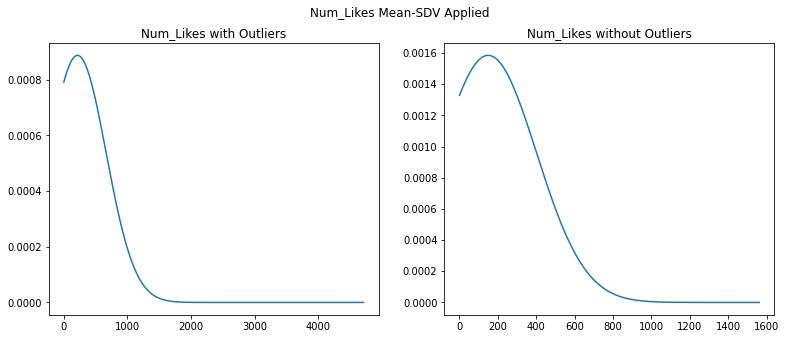

Mean: 215.04
Median: 58.00
STD: 449.47
+3 STD: 1563.46
-3 STD: -1133.37
Mean wo Outliers: 149.56
STD wo Outliers: 251.66


In [217]:
num_likes_mean, num_likes_sd, num_likes_wo_outliers, num_likes_outliers = remove_outliers_and_plot(field="num_likes", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_likes'].mean():.2f}")
print(f"Median: {df_1['num_likes'].median():.2f}")
print(f"STD: {df_1['num_likes'].std():.2f}")
print(f"+3 STD: {df_1['num_likes'].mean() + (3 * df_1['num_likes'].std()):.2f}")
print(f"-3 STD: {df_1['num_likes'].mean() - (3 * df_1['num_likes'].std()):.2f}")
print(f"Mean wo Outliers: {num_likes_mean:.2f}")
print(f"STD wo Outliers: {num_likes_sd:.2f}")

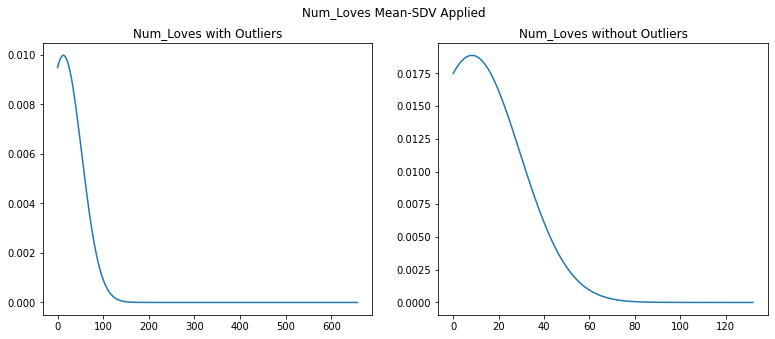

Mean: 12.73
Median: 0.00
STD: 39.97
+3 STD: 132.65
-3 STD: -107.19
Mean wo Outliers: 8.24
STD wo Outliers: 21.14


In [218]:
num_loves_mean, num_loves_sd, num_loves_wo_outliers, num_loves_outliers = remove_outliers_and_plot(field="num_loves", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_loves'].mean():.2f}")
print(f"Median: {df_1['num_loves'].median():.2f}")
print(f"STD: {df_1['num_loves'].std():.2f}")
print(f"+3 STD: {df_1['num_loves'].mean() + (3 * df_1['num_loves'].std()):.2f}")
print(f"-3 STD: {df_1['num_loves'].mean() - (3 * df_1['num_loves'].std()):.2f}")
print(f"Mean wo Outliers: {num_loves_mean:.2f}")
print(f"STD wo Outliers: {num_loves_sd:.2f}")

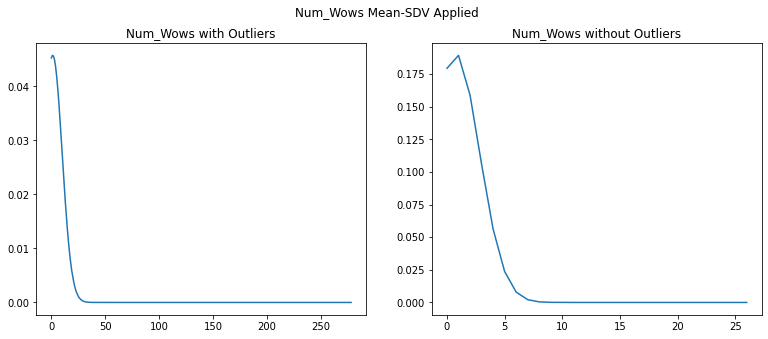

Mean: 1.29
Median: 0.00
STD: 8.72
+3 STD: 27.45
-3 STD: -24.87
Mean wo Outliers: 0.74
STD wo Outliers: 2.09


In [219]:
num_wows_mean, num_wows_sd, num_wows_wo_outliers, num_wows_outliers = remove_outliers_and_plot(field="num_wows", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_wows'].mean():.2f}")
print(f"Median: {df_1['num_wows'].median():.2f}")
print(f"STD: {df_1['num_wows'].std():.2f}")
print(f"+3 STD: {df_1['num_wows'].mean() + (3 * df_1['num_wows'].std()):.2f}")
print(f"-3 STD: {df_1['num_wows'].mean() - (3 * df_1['num_wows'].std()):.2f}")
print(f"Mean wo Outliers: {num_wows_mean:.2f}")
print(f"STD wo Outliers: {num_wows_sd:.2f}")

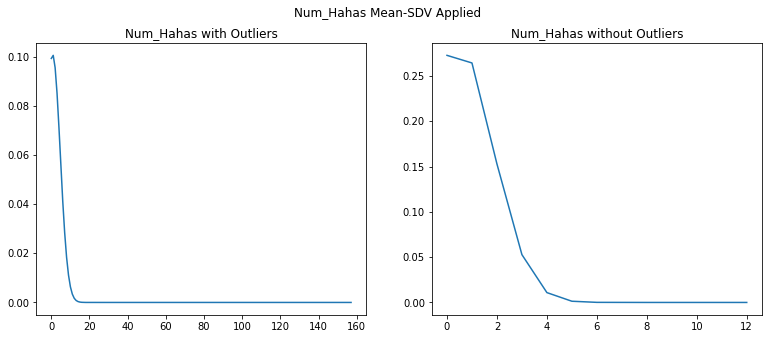

Mean: 0.70
Median: 0.00
STD: 3.96
+3 STD: 12.57
-3 STD: -11.18
Mean wo Outliers: 0.44
STD wo Outliers: 1.39


In [220]:
num_hahas_mean, num_hahas_sd, num_hahas_wo_outliers, num_hahas_outliers = remove_outliers_and_plot(field="num_hahas", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_hahas'].mean():.2f}")
print(f"Median: {df_1['num_hahas'].median():.2f}")
print(f"STD: {df_1['num_hahas'].std():.2f}")
print(f"+3 STD: {df_1['num_hahas'].mean() + (3 * df_1['num_hahas'].std()):.2f}")
print(f"-3 STD: {df_1['num_hahas'].mean() - (3 * df_1['num_hahas'].std()):.2f}")
print(f"Mean wo Outliers: {num_hahas_mean:.2f}")
print(f"STD wo Outliers: {num_hahas_sd:.2f}")

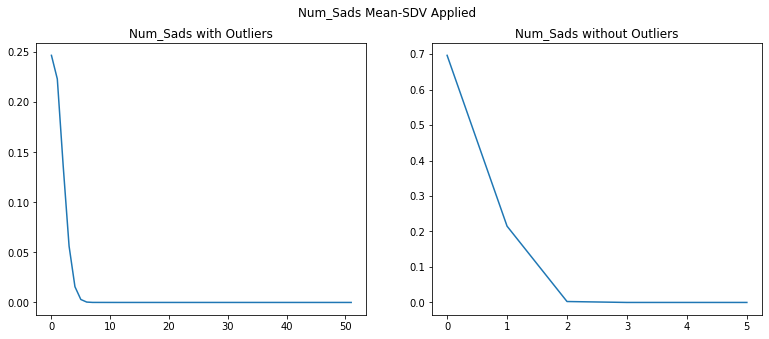

Mean: 0.24
Median: 0.00
STD: 1.60
+3 STD: 5.04
-3 STD: -4.55
Mean wo Outliers: 0.14
STD wo Outliers: 0.56


In [221]:
num_sads_mean, num_sads_sd, num_sads_wo_outliers, num_sads_outliers = remove_outliers_and_plot(field="num_sads", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_sads'].mean():.2f}")
print(f"Median: {df_1['num_sads'].median():.2f}")
print(f"STD: {df_1['num_sads'].std():.2f}")
print(f"+3 STD: {df_1['num_sads'].mean() + (3 * df_1['num_sads'].std()):.2f}")
print(f"-3 STD: {df_1['num_sads'].mean() - (3 * df_1['num_sads'].std()):.2f}")
print(f"Mean wo Outliers: {num_sads_mean:.2f}")
print(f"STD wo Outliers: {num_sads_sd:.2f}")

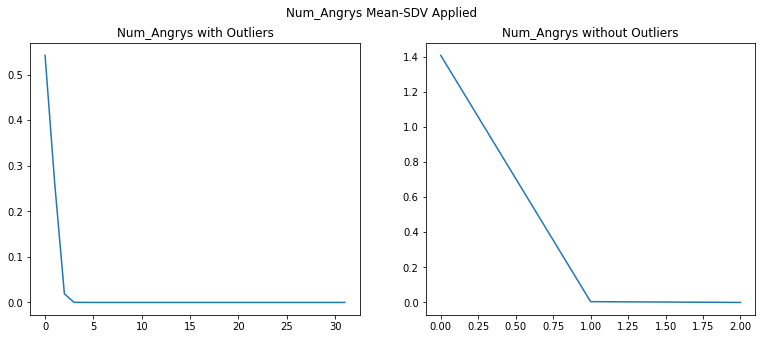

Mean: 0.11
Median: 0.00
STD: 0.73
+3 STD: 2.29
-3 STD: -2.07
Mean wo Outliers: 0.06
STD wo Outliers: 0.28


In [222]:
num_angrys_mean, num_angrys_sd, num_angrys_wo_outliers, num_angrys_outliers = remove_outliers_and_plot(field="num_angrys", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_angrys'].mean():.2f}")
print(f"Median: {df_1['num_angrys'].median():.2f}")
print(f"STD: {df_1['num_angrys'].std():.2f}")
print(f"+3 STD: {df_1['num_angrys'].mean() + (3 * df_1['num_angrys'].std()):.2f}")
print(f"-3 STD: {df_1['num_angrys'].mean() - (3 * df_1['num_angrys'].std()):.2f}")
print(f"Mean wo Outliers: {num_angrys_mean:.2f}")
print(f"STD wo Outliers: {num_angrys_sd:.2f}")

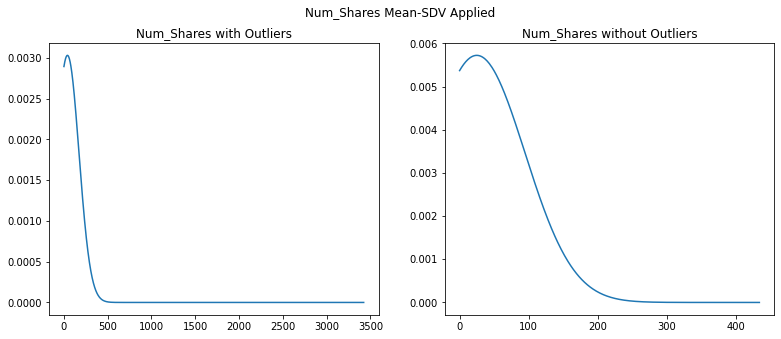

Mean: 40.02
Median: 0.00
STD: 131.60
+3 STD: 434.82
-3 STD: -354.78
Mean wo Outliers: 24.86
STD wo Outliers: 69.68


In [223]:
num_shares_mean, num_shares_sd, num_shares_wo_outliers, num_shares_outliers = remove_outliers_and_plot(field="num_shares", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_shares'].mean():.2f}")
print(f"Median: {df_1['num_shares'].median():.2f}")
print(f"STD: {df_1['num_shares'].std():.2f}")
print(f"+3 STD: {df_1['num_shares'].mean() + (3 * df_1['num_shares'].std()):.2f}")
print(f"-3 STD: {df_1['num_shares'].mean() - (3 * df_1['num_shares'].std()):.2f}")
print(f"Mean wo Outliers: {num_shares_mean:.2f}")
print(f"STD wo Outliers: {num_shares_sd:.2f}")

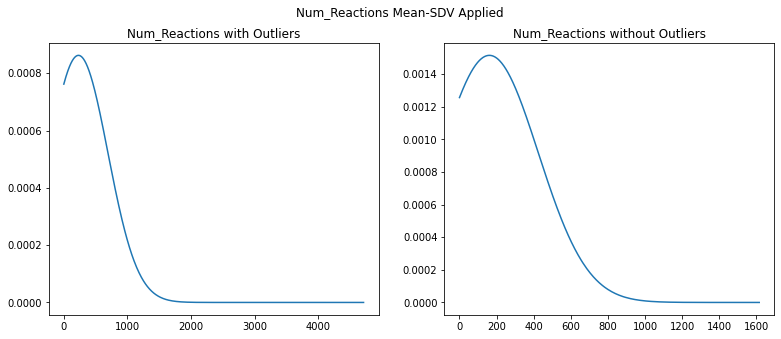

Mean: 230.12
Median: 59.50
STD: 462.63
+3 STD: 1617.99
-3 STD: -1157.76
Mean wo Outliers: 161.09
STD wo Outliers: 263.16


In [310]:
num_reactions_mean, num_reactions_sd, num_reactions_wo_outliers, num_reactions_outliers = remove_outliers_and_plot(field="num_reactions", n_sdt=3, dataset=df_2)

print(f"Mean: {df_1['num_reactions'].mean():.2f}")
print(f"Median: {df_1['num_reactions'].median():.2f}")
print(f"STD: {df_1['num_reactions'].std():.2f}")
print(f"+3 STD: {df_1['num_reactions'].mean() + (3 * df_1['num_reactions'].std()):.2f}")
print(f"-3 STD: {df_1['num_reactions'].mean() - (3 * df_1['num_reactions'].std()):.2f}")
print(f"Mean wo Outliers: {num_reactions_mean:.2f}")
print(f"STD wo Outliers: {num_reactions_sd:.2f}")

Once the outliers are obtained, they are removed from the dataset; below, the difference in the row numbers can be checked out between the data with outliers and the dataset without outliers:

In [311]:
df_3 = df_2.copy(deep=True)
df_3.drop(num_likes_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_loves_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_wows_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_hahas_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_sads_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_angrys_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_shares_outliers[:,0], axis=0, inplace=True, errors='ignore')
df_3.drop(num_reactions_outliers[:,0], axis=0, inplace=True, errors='ignore')


print(f"df_2: {df_2.shape}")
print(f"df_3: {df_3.shape}")


df_2: (7050, 9)
df_3: (6512, 9)


The features are plotted considering the number of reactions as the y-axis to graphically see if there is a clustering pattern in the data. The first set of charts corresponds to the data with outliers; the second corresponds to the data without outliers.

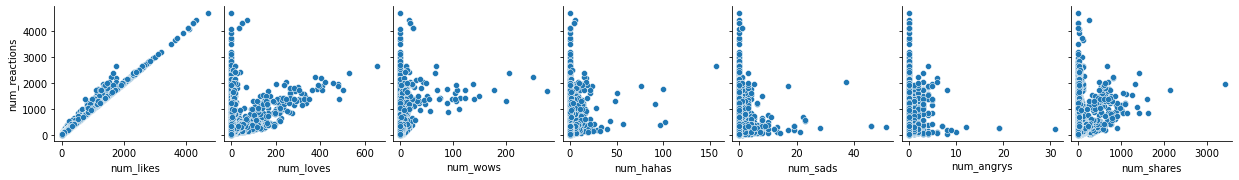

In [312]:
sns.pairplot(data=df_2, x_vars=["num_likes", "num_loves", "num_wows", "num_hahas", "num_sads", "num_angrys", "num_shares"], y_vars=["num_reactions"])
plt.show()

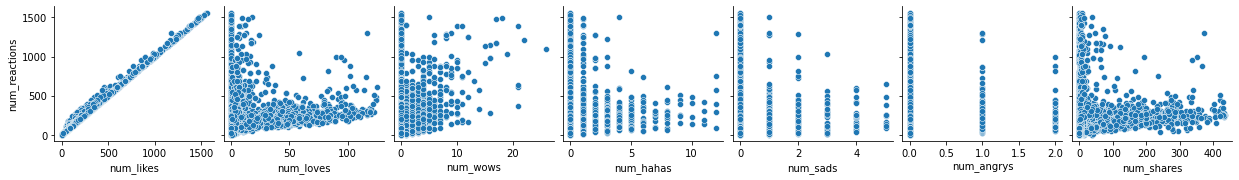

In [313]:
sns.pairplot(data=df_3, x_vars=["num_likes", "num_loves", "num_wows", "num_hahas", "num_sads", "num_angrys", "num_shares"], y_vars=["num_reactions"])
plt.show()

Based on the previous chart, the features that represent some kind of clustering shapes are:

- num_loves
- num_wows
- num_shares

These features plus num_reactions will be selected to apply the k-means algorithm. The rest are discarded because they have just a few values or do not have a clustering shape.

### 4) Split data

In this step, the data is split, selecting only the previously mentioned columns, and the target or label is saved as a "y" variable. Because we are working with an unsupervised model, this target has the only purpose to validate that the model should detect a number of clusters close to four because the unique values in the target are four: 

- photo
- video
- state
- link

In [319]:
X = df_3[["num_loves", "num_wows", "num_shares", "num_reactions"]]
y = df_3["status_type"]

### 4) Scaling features

Because the k-Means algorithm measure distances between the instances and the centroids, this model is affected if the data has different scales of magnitude, so the features will be scaled using the standard deviation.

In [320]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_sc

array([[ 4.33213084e+00,  1.43673142e+00,  3.72739249e+00,
         1.68013222e+00],
       [-3.79918751e-01, -3.47515292e-01, -3.44981655e-01,
         3.98732035e-02],
       [ 6.95657785e-01,  2.47233612e-01,  5.40992874e-01,
         3.73118440e-01],
       ...,
       [-3.28700820e-01, -3.47515292e-01, -3.44981655e-01,
        -6.00650108e-01],
       [-2.77482890e-01, -3.47515292e-01, -3.02657362e-03,
         9.09773106e-01],
       [-3.79918751e-01, -3.47515292e-01, -3.44981655e-01,
        -5.35732205e-01]])

### 5) Training Model

#### K-mean and Elbow Method

The model is trained using different numbers of clusters. Using the elbow method, it looks like four is the best number, but it is not as clear as seen in the following graph. To make sure what is the best number of clusters, the silhouette score will be used next.

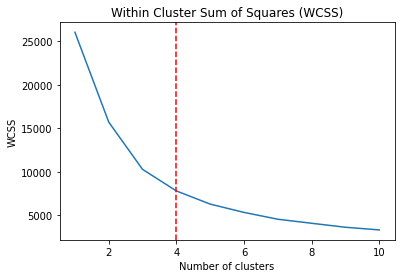

In [323]:
features = X_sc
wcss = []
k= 10

for i in range(k):
    kmeans = KMeans(n_clusters = i + 1, random_state=100)
    kmeans.fit(features)
    wcss.append(kmeans.inertia_)

number_clusters = np.arange(1,11)
plt.plot(number_clusters, wcss)
plt.title('Within Cluster Sum of Squares (WCSS)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.axvline(4, linestyle='--', color='r')
plt.show()

#### Silhouette Score

The silhouette coefficient, which varies from -1 to 1, calculates how near a point in one cluster is to a point in its closest neighbors (Henrique, 2021).

The formula to obtain the Silhouette score is the following:

$$ \frac{b - a}{ max(a, b) } $$

$ a: mean\ distance\ to\ other\ instances\ in\ the\ same\ cluster $

$ b: mean\ distance\ to\ other\ instances\ in\ other\ clusters $



When $ 𝑏 = 𝑎 $, the score is $0$, meaning the instance is in the decision boundary between 2 clusters.

When  $𝑏$ is much greater than $𝑎$, the score is close to $+1$, which means the instance is close to the center of the cluster.

When $𝑎$ is much greater than $𝑏$, the score is close to $-1$, which means the instance was assigned to the wrong cluster because it is clustered to another group.

This algorithm helps to select the best number of clusters when the elbow method is not so straightforward. According to this score, the best number of clusters is four.

Silhouette Score cluster 2 = 0.7251
Silhouette Score cluster 3 = 0.7366
Silhouette Score cluster 4 = 0.7404
Silhouette Score cluster 5 = 0.6517
Silhouette Score cluster 6 = 0.6809
Silhouette Score cluster 7 = 0.6254
Silhouette Score cluster 8 = 0.6403
Silhouette Score cluster 9 = 0.6420
Silhouette Score cluster 10 = 0.6436

Best Silhouette score: 0.7404 - Number of cluster: 4


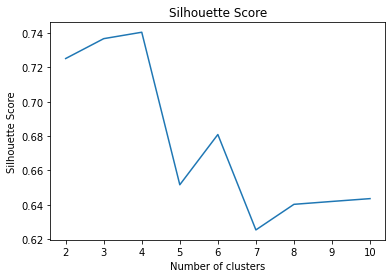

In [322]:
k = 10
max_score = { 
    'num_of_clusters': 0,
    'silhouette': 0
}
silhouette_scores = []

for i in range(2, k + 1):
    kmeans = KMeans(n_clusters=i, random_state=100).fit(features)

    silhouette = silhouette_score(features, kmeans.labels_) 
    silhouette_scores.append(silhouette)
    
    if silhouette >= max_score["silhouette"]:
        max_score["num_of_clusters"] = i
        max_score["silhouette"] = silhouette
    
    print(f"Silhouette Score cluster {i} = {silhouette:.4f}")
    
print(f"\nBest Silhouette score: {max_score['silhouette']:.4f} - Number of cluster: {max_score['num_of_clusters']}")

plt.plot(range(2, k + 1), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

### Plot the Clusters

Below are each feature graph according to the number of clusters identified by the algorithm. Some zones are clearly delimited, but in other cases, some points are overlapping between the clusters. This is probably due to the data used. If the values are counted, most of the data were classified are reactions from photos and videos, so the overlapped values are due to the limited amount of data classified as reactions from links and states.

In [372]:
kmeans = KMeans(n_clusters = 4, random_state=100)
kmeans.fit(features)

labels = kmeans.labels_

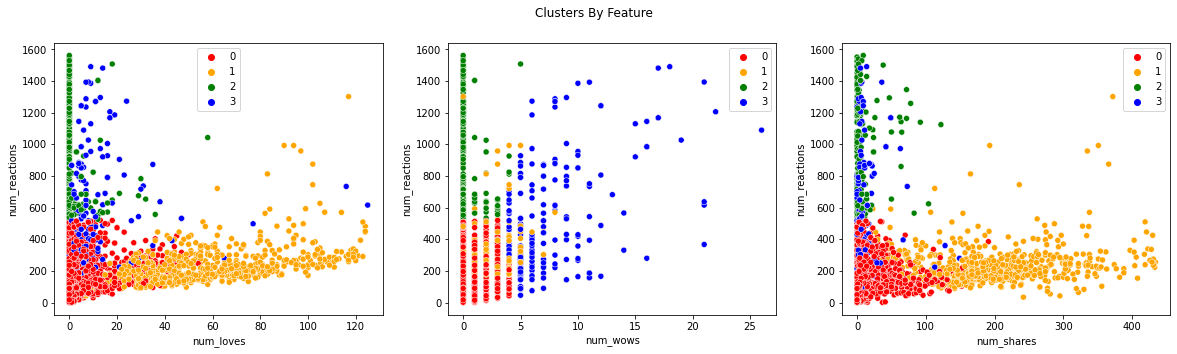

In [373]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (20, 5))
fig.suptitle(f"Clusters By Feature")

sns.scatterplot(x=X["num_loves"], y=X["num_reactions"], hue=labels, palette=['red', 'orange', 'green', 'blue'], ax=ax1)
sns.scatterplot(x=X["num_wows"], y=X["num_reactions"], hue=labels, palette=['red', 'orange', 'green', 'blue'], ax=ax2)
sns.scatterplot(x=X["num_shares"], y=X["num_reactions"], hue=labels, palette=['red', 'orange', 'green', 'blue'], ax=ax3)

plt.show()

### Conclusions

A dataset from Facebook was used to identify clusters through an unsupervised algorithm. A step-by-step methodology was followed by first preprocessing the data by cleaning the data, treating missing values, outlier detection, feature selection and scaling. After training a K-Means model with different numbers of clusters and according to Elbow Method and Silhouette score, the best number of clusters was four, which corresponds precisely to the number of categories the data has previously. These categories were removed before training the model and were used only for comparison reasons.